# Imports

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
%matplotlib inline 
#  !pip3 install mpld3
# import mpld3
#pld3.enable_notebook() causes plotting to not work???

from scipy.integrate import odeint
# !pip3 install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian, exponential

from time import time
import warnings
warnings.filterwarnings('ignore')
# JSM added
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys

In [3]:
from Cluster import * 

In [55]:
bd = BaseData('data_all_base')

reading in data from data_all_base ...
elapsed:  19.534440279006958


In [5]:
# clusdtypes should be in ['JRP1','ORP1','JWP1','OWP1','JRT1','ORT1','JWT1','OWT1']
# database JHU/OWID  (J/O) 
# report_correct T or F   (R/W)
# syncat peak/thresh  (P/T)
clusdtype='JRP1'
ClData = get_cluster_data(clusdtype)

reading in data from ./pks/data_cluster_JRP1.pk ...


In [6]:
from model_fits_nodata import *  # including ModelFit class definition.

loading data.py...
done with data.py.
making the models...
SEI3R
SC3EI3R
SC3UEI3R
done with the models.


In [13]:
# eliminate countries with no population data (needed for normalizing death stats for fits)

#for country in countries:
#    if population_owid[country][0] == 0:
#        print(country)
        
countries = [cc for cc in bd.countries_common if bd.population_owid[cc][-2] > 0]
print(len(countries),'countries with population data')
countries_zp = [cc for cc in bd.countries_common if bd.population_owid[cc][-2] == 0]
print('common countries without population data',countries_zp)
cluster_countries = [c for c in ClData.clusdata_all['deaths']]
print(len(cluster_countries),'cluster countries')


187 countries with population data
common countries without population data []
77 cluster countries


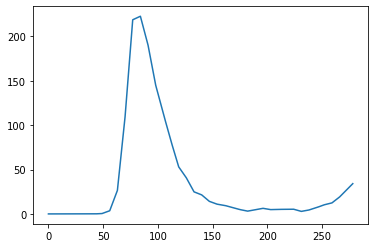

In [15]:
plt.plot(bd.covid_ts[b'new_deaths_corrected_smoothed'][('Germany','')])

In [23]:
[x for x in ClData.clusdata_all if '__' not in x]

['deaths',
 'cases',
 'cases_lin2020',
 'cases_pwlfit',
 'cases_nonlin',
 'cases_nonlinr']

# Curve Fitting Example

We want to fit the following curve:

In [8]:
def exponential_growth(x,A,k):
    return A*np.exp(x*k)

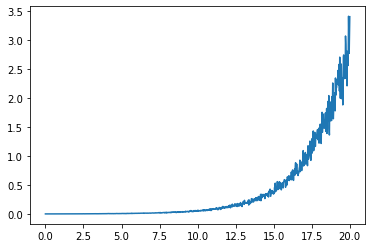

In [9]:
np.random.seed(42)
x = np.linspace(0, 20.0, 1001)

data = (exponential_growth(x, 0.001, 0.4) * (1.0 + np.random.normal(scale=0.1, size=x.size)))  # exponential distr. with some noise
plt.plot(x, data);

So we define a function that takes x as the first argument, and then the parameters to be fitted (a, b, c)

In [10]:
def f(x, a, b):
    return exponential_growth(x, a, b) 

In [11]:
mod = lmfit.Model(f)
# we set the parameters (and some initial parameter guesses)
mod.set_param_hint("a", value=0.02, vary=True)
mod.set_param_hint("b", value=0.5, vary=True)

params = mod.make_params()

In [12]:
result = mod.fit(data, params, method="leastsq", x=x)  # fitting

{'a': 0.0011015708523488322, 'b': 0.3951473987912008}

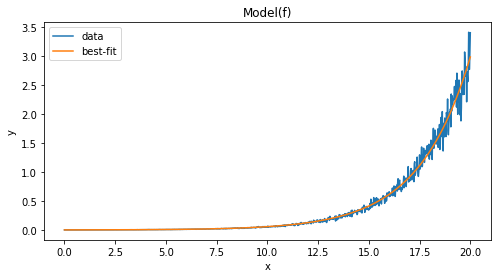

In [13]:
plt.figure(figsize=(8,4))
result.plot_fit(datafmt="-");
result.best_values

In [14]:
result

# Use `Modelfit.solvefit()` with `lmfit`

In [119]:
bd = BaseData('data_all_base')

reading in data from data_all_base ...
elapsed:  82.80223083496094


In [220]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
exec(open('ModelFit.py','r').read())

In [221]:
country = 'Germany'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',basedata=bd,data=ClData.clusdata_all,country=country,run_id="_test1",data_src='cluster')

loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_test1.pk :


In [222]:
params_init_min_max = {
                   "beta_1": (0.4, 0.3, 0.6,0.001),
                   #"mu": (.05,0.03,0.15,0.001),
                   "c_0": (0.1, 0.05, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   #"c_2": (5., 1., 8., 0.01), 
                    "logI_0": (-6.,-9.,-5.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [223]:
MyModel.params

{'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.05,
 'c_0': 0.1,
 'c_1': 0.07,
 'c_2': 5.0,
 'N': 1}

In [224]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
#fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='differential_evolution',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths'],fit_data=['deaths'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  2.320218801498413
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 60
    # data points      = 153
    # variables        = 4
    chi-square         = 1.8465e-06
    reduced chi-square = 1.2392e-08
    Akaike info crit   = -2781.59939
    Bayesian info crit = -2769.47763
[[Variables]]
    beta_1:  0.30000470 +/- 99.2619296 (33086.79%) (init = 0.4)
    c_0:     0.05006909 +/- 1266.59201 (2529688.31%) (init = 0.1)
    c_1:     3.7798e-05 +/- 77.4393615 (204876344.37%) (init = 0.07)
    logI_0: -8.99978306 +/- 6.32320901 (70.26%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(c_0, c_1)       = -1.000
    C(beta_1, logI_0) = -0.990
    C(c_1, logI_0)    =  0.972
    C(c_0, logI_0)    = -0.971
    C(beta_1, c_1)    = -0.929
    C(beta_1, c_0)    =  0.928


In [227]:
[x for x in MyModel.data]

['deaths',
 'cases',
 'cases_lin2020',
 'cases_pwlfit',
 'cases_nonlin',
 'cases_nonlinr']

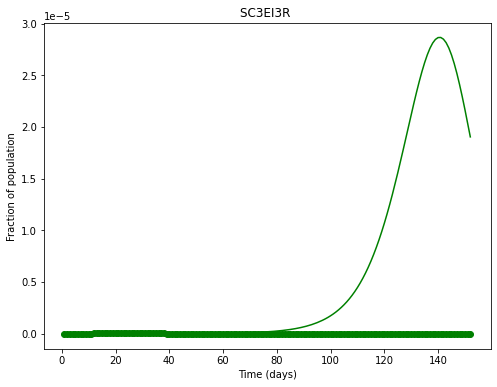

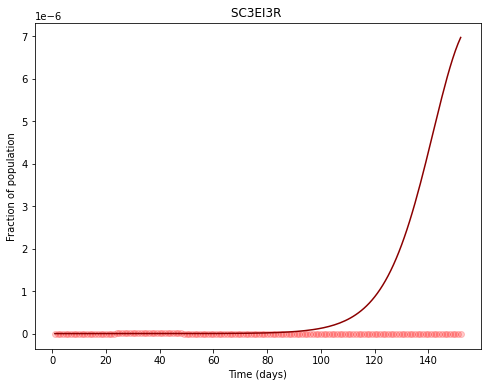

In [226]:
#MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
#MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])
MyModel.solveplot(['confirmed'],datasets=['cases'])
MyModel.solveplot(['deaths'],datasets=['deaths'])

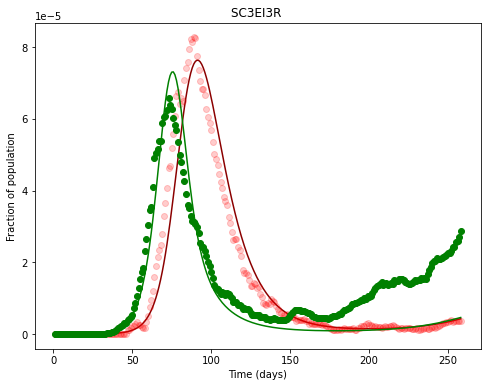

In [21]:
MyModel.solveplot(['deaths','confirmed'],datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],mag={'deaths':30.})

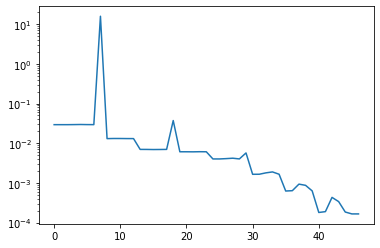

In [22]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

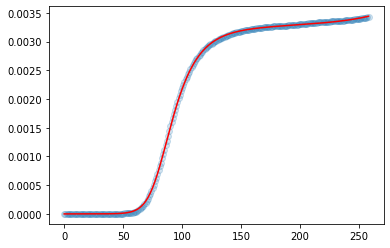

In [23]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

In [24]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

['beta_1', 'c_0', 'c_1', 'logI_0']

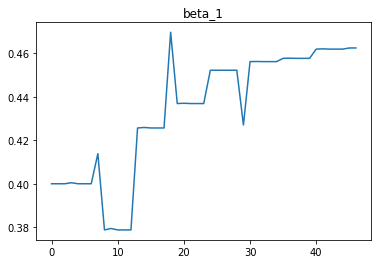

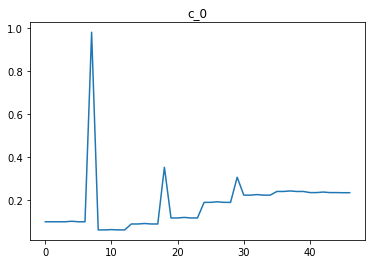

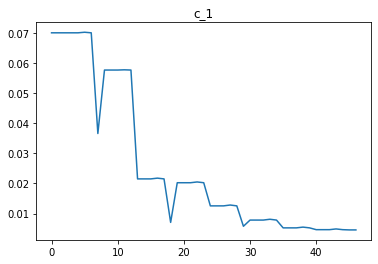

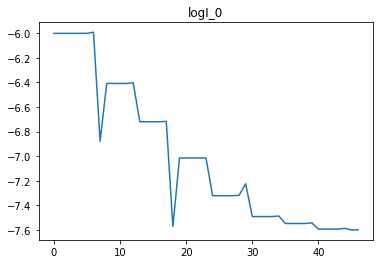

In [25]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

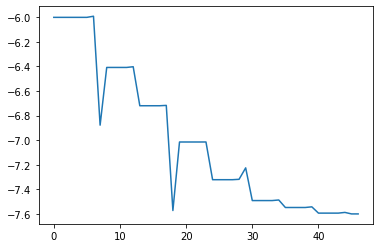

In [26]:
p0 = [x[pars[-1]] for x in MyModel.paramall]
plt.plot(p0);

In [27]:
# outfit.params
MyModel.params

{'beta_1': 0.4624965115578361,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.1,
 'c_0': 0.23500360824282207,
 'c_1': 0.004561537028510088,
 'c_2': 10.0,
 'N': 1}

## Trying different fitting methods...

see [lmfit documentation](https://lmfit.github.io/lmfit-py/fitting.html) on fitting methods for the list.

In this section I am using the same basic template to repeat the basic fitting operation with different fitting methods.

All seem to work.  Some comments:
* some (e.g. leastsq, differential_evolution) seem to hop all over the place, giving wildly varying residual socre and param convergence.
* some (powell, cobyla)seem to converge fast at beginning, with a slow tail (view residual plot with semilog)
* initially chose nelder, because of consistent gradual convergence.
* then switched back to leastsq as it gave fast reliable results after other problems had been resolved

## USA

### fit deaths+confirmed

In [28]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test1",data_src='owid')

loaded params from  /Users/john/projects/Covid-19/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_United States_test1.pk :


In [29]:
params_init_min_max = {
                   "beta_1": (0.4, 0.3, 0.6,0.001),
                   "mu": (.05,0.03,0.15,0.001),
                   "c_0": (0.1, 0.05, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   "c_2": (5., 1., 8., 0.01), 
                    "logI_0": (-6.,-9.,-5.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [30]:
MyModel.params

{'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.05,
 'c_0': 0.1,
 'c_1': 0.07,
 'c_2': 5.0,
 'N': 1}

In [31]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
# fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_nonlinr_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  3.848548173904419
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 241
    # data points      = 518
    # variables        = 6
    chi-square         = 0.00139337
    reduced chi-square = 2.7214e-06
    Akaike info crit   = -6631.86951
    Bayesian info crit = -6606.36965
[[Variables]]
    beta_1:  0.30001730 +/- 0.12910327 (43.03%) (init = 0.4)
    mu:      0.03790057 +/- 6.7712e-04 (1.79%) (init = 0.05)
    c_0:     0.54195963 +/- 0.09678630 (17.86%) (init = 0.1)
    c_1:     0.09983813 +/- 0.00929839 (9.31%) (init = 0.07)
    c_2:     7.92128573 +/- 7.33566092 (92.61%) (init = 5)
    logI_0: -5.20536724 +/- 1.05431648 (20.25%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(c_0, logI_0)    =  0.998
    C(beta_1, c_2)    =  0.997
    C(beta_1, c_0)    = -0.994
    C(beta_1, logI_0) = -0.993
    C(c_0, c_2)       = -0.984
    C(c_2, logI_0)    = -0.982
    C(c_0, c_1)       = -0.333
    C(c_1, logI_0)    = -0.326
   

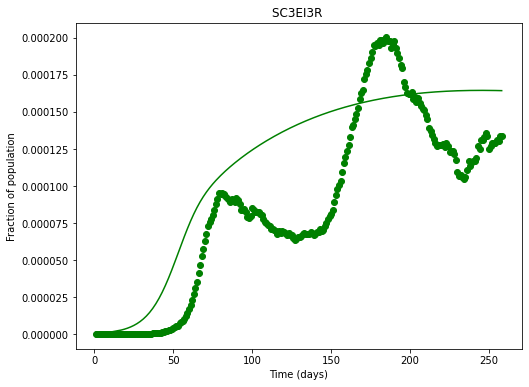

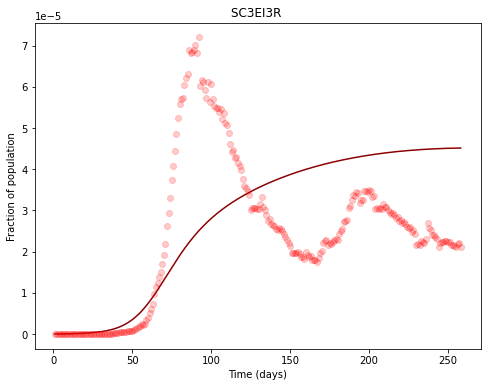

In [32]:
MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])

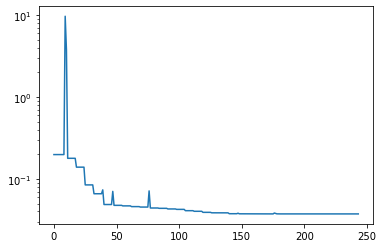

In [33]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

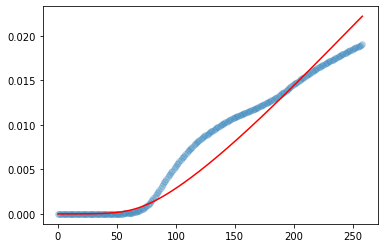

In [34]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

In [35]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

['beta_1', 'mu', 'c_0', 'c_1', 'c_2', 'logI_0']

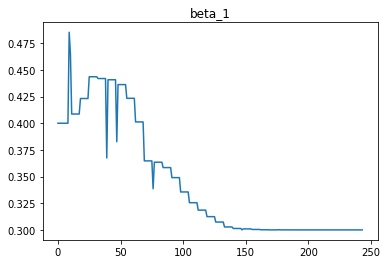

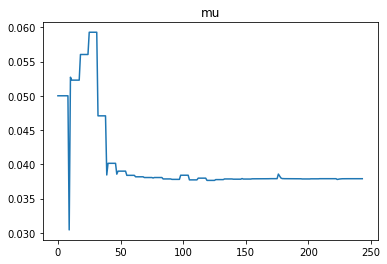

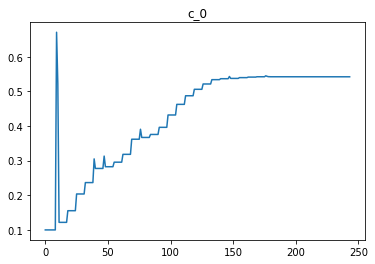

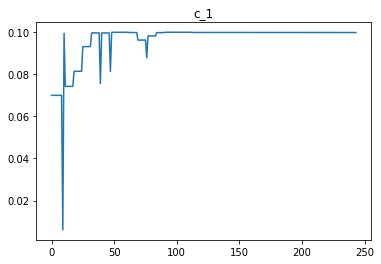

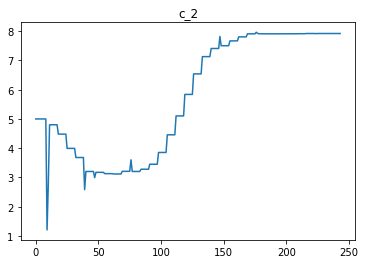

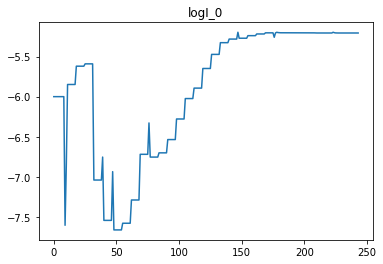

In [36]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

### fit deaths+ testing adjusted confirmed

In [37]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test1",data_src='owid')

loaded params from  /Users/john/projects/Covid-19/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_United States_test1.pk :


In [38]:
params_init_min_max = {
                   "beta_1": (0.4, 0.3, 0.6,0.001),
                   "mu": (.05,0.03,0.15,0.001),
                   "c_0": (0.1, 0.05, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   "c_2": (5., 1., 8., 0.01), 
                    "logI_0": (-6.,-9.,-5.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [39]:
MyModel.params

{'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.05,
 'c_0': 0.1,
 'c_1': 0.07,
 'c_2': 5.0,
 'N': 1}

In [40]:
testdata = covid_owid_ts['confirmed_corrected_smoothed']
print(len(testdata),len(testdata['United States']))
testdatar = covid_owid_ts['confirmed_nonlinr_corrected_smoothed']
print(len(testdatar),len(testdatar['United States']))


213 259
187 259


In [41]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
# fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_nonlinr_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  3.3424630165100098
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 241
    # data points      = 518
    # variables        = 6
    chi-square         = 0.00139337
    reduced chi-square = 2.7214e-06
    Akaike info crit   = -6631.86951
    Bayesian info crit = -6606.36965
[[Variables]]
    beta_1:  0.30001730 +/- 0.12910327 (43.03%) (init = 0.4)
    mu:      0.03790057 +/- 6.7712e-04 (1.79%) (init = 0.05)
    c_0:     0.54195963 +/- 0.09678630 (17.86%) (init = 0.1)
    c_1:     0.09983813 +/- 0.00929839 (9.31%) (init = 0.07)
    c_2:     7.92128573 +/- 7.33566092 (92.61%) (init = 5)
    logI_0: -5.20536724 +/- 1.05431648 (20.25%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(c_0, logI_0)    =  0.998
    C(beta_1, c_2)    =  0.997
    C(beta_1, c_0)    = -0.994
    C(beta_1, logI_0) = -0.993
    C(c_0, c_2)       = -0.984
    C(c_2, logI_0)    = -0.982
    C(c_0, c_1)       = -0.333
    C(c_1, logI_0)    = -0.326
  

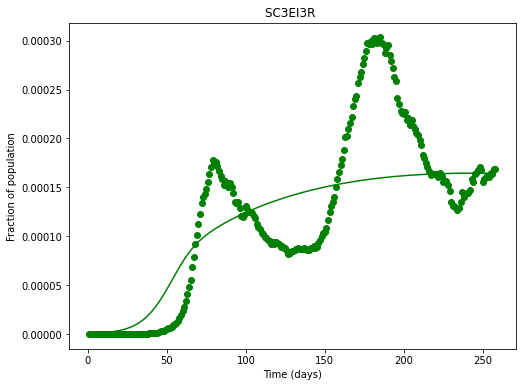

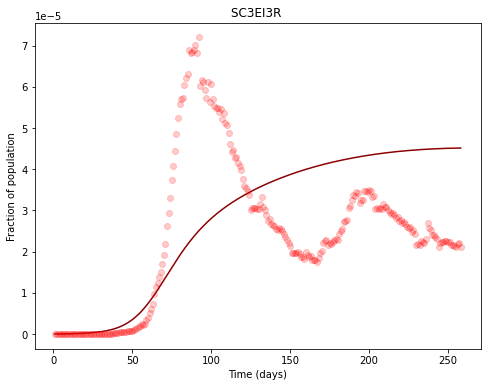

In [45]:
MyModel.solveplot(['confirmed'],datasets=['confirmed_nonlinr_corrected_smoothed'])
MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])

In [ ]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [ ]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

In [ ]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

### fit deaths only

In [ ]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
# fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

In [ ]:
MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])

In [ ]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

In [ ]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

In [ ]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

In [ ]:
p0 = [x[pars[-1]] for x in MyModel.paramall]
plt.plot(p0);

# ModelFit with lmfit integrated

## SC3EI3R 

### Test on Germany with method Nelder

In [47]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
exec(open('ModelFit.py','r').read())

In [51]:
[x for x in bd.covid_owid_ts['deaths']]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 2.0,
 3.0,
 5.0,
 5.0,
 8.0,
 12.0,
 13.0,
 13.0,
 13.0,
 43.0,
 45.0,
 67.0,
 94.0,
 126.0,
 149.0,
 198.0,
 253.0,
 325.0,
 389.0,
 455.0,
 583.0,
 732.0,
 872.0,
 1017.0,
 1158.0,
 1342.0,
 1434.0,
 1607.0,
 1861.0,
 2107.0,
 2373.0,
 2544.0,
 2673.0,
 2799.0,
 2969.0,
 3254.0,
 3569.0,
 3868.0,
 4110.0,
 4294.0,
 4404.0,
 4598.0,
 4879.0,
 5094.0,
 5321.0,
 5500.0,
 5640.0,
 5750.0,
 5913.0,
 6115.0,
 6288.0,
 6481.0,
 6575.0,
 6649.0,
 6692.0,
 6831.0,
 6996.0,
 7119.0,
 7266.0,
 7369.0,
 7395.0,
 7417.0,
 7533.0,
 7634.0,
 7723.0,
 7824.0,
 7881.0,
 7914.0,
 7935.0,
 8007.0,
 8090.0,
 8147.0,
 8174.0,
 8216.0,
 8247.0,
 8257.0,
 8302.0,
 8349.0,
 8411.0,
 8450.0,
 8489.0,
 8500.0,
 8511.0,
 8522.

In [49]:
bd.covid_owid_ts['deaths']['dates'][-1]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [48]:
country = 'Germany'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',basedata=bd,data=bd.covid_owid_ts,country=country,run_id="_test2")

loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_test2.pk :
data_src =  owid


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
params_init_min_max = {"beta_1": (0.2, 0., 2.,0.001),
                   "mu": (.1,0.,.2,0.001),
                   "c_0": (0.1, 0., 1.0,0.001), 
                   "c_1": (0.05, 0.0, 0.5,0.001),
                   "c_2": (2., 0.,20.,0.01), 
                    "logI_0": (-6.,-10.,0.0,0.01)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [ ]:
MyModel.params

In [ ]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],diag=False,report=True)

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

#### slider plot

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
params_init_min_max_slider = params_init_min_max.copy()
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max_slider)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('ode'),**sliderparams)
    display(w)

In [ ]:
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
MyModel.prparams()

### Test on USA

In [ ]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test2",new=True)

In [ ]:
params_init_min_max = {"beta_1": (0.4, 0., 2.,0.001),
                   "mu": (.1,0.,.2,0.001),
                   "c_0": (0.1, 0., 1.0,0.001), 
                   "c_1": (0.05, 0.0, 0.5,0.001),
                   "c_2": (2., 0.,20.,0.01), 
                    "logI_0": (-6.,-10.,0.0,0.01)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [ ]:
countries[0]

In [ ]:
short_countries = ['United States','Spain','Peru','Italy','Germany','Sweden','Iran','Russia']

In [ ]:
params_init_min_max = {"beta_1": (0.2, 0.0, 2.0,0.001),
                   "mu": (.1,0.,.2,0.001),
                   "c_0": (0.1, 0., 1.0,0.001), 
                   "c_1": (0.05, 0.0, 0.5,0.001),
                   "c_2": (2., 0.,20.,0.01), 
                    "logI_0": (-6.,-10.,0.0,0.01)}
MyModel = ModelFit('SC3EI3R',country=country,run_id="_scan",new=True) # run_id labels parameter dump files
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})
MyModel.fit(params_init_min_max,fit_method=mymethod,diag=True,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

In [ ]:
cnt=0
max_cols=8
max_rows=int(len(short_countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,3*max_rows))


# params optimized in fit
params_init_min_max = {"beta_1": (0.4, 0.1, 0.6),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5., 2.,20.),
                       "logI_0": (-6.,-10.,0.0)}


for idx, country  in enumerate(short_countries):
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    try:
        MyModel = ModelFit('SC3EI3R',country=country,run_id="_scan",new=True) # run_id labels parameter dump files
        MyModel.fit(params_init_min_max,diag=False,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])
        MyModel.solveplot(species=['deaths','confirmed'],datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],axis=axes[row,col],newplot=False)       
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.savefig('scan.SC3EI3R.pdf')
plt.show()

In [ ]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

In [ ]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

In [ ]:
params_init_min_max = {"beta_1": (0.4, 0, 2.0,0.001),
                   "mu": (.1,0.,.2,0.001),
                   "c_0": (0.1, 0., 1.0,0.001), 
                   "c_1": (0.05, 0.0, 0.5,0.001),
                   "c_2": (2., 0.,20.,0.01), 
                    "logI_0": (-6.,-10.,0.0,0.01)}
MyModel = ModelFit('SC3EI3R',country=country,run_id="_scan",new=True) # run_id labels parameter dump files
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})
MyModel.fit(params_init_min_max,fit_method=mymethod,diag=True,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

[[Variables]]
    beta_1:  0.32665845 +/- 0.46153068 (141.29%) (init = 0.2)
    mu:      0.09205437 +/- 0.06980213 (75.83%) (init = 0.1)
    c_0:     0.18519038 +/- 0.21390488 (115.51%) (init = 0.1)
    c_1:     0.16174352 +/- 0.16259196 (100.52%) (init = 0.05)
    c_2:     9.32518629 +/- 6.93746369 (74.39%) (init = 2)
    logI_0: -6.00779344 +/- 2.75916716 (45.93%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta_1, c_0) = -0.441
    C(beta_1, c_2) =  0.229
    C(c_1, c_2)    =  0.225
    C(c_0, c_1)    =  0.124
    C(beta_1, mu)  = -0.108
    C(mu, c_0)     =  0.107

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

In [ ]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

In [ ]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

#### slider plot

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
params_init_min_max_slider = params_init_min_max.copy()
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max_slider)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('ode'),**sliderparams)
    display(w)

In [ ]:
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
MyModel.prparams()

### Country scan

In [ ]:
countries[0]

In [ ]:
short_countries = ['United States','Spain','Peru','Italy','Germany','Sweden','Iran','Russia']

In [ ]:
cnt=0
max_cols=8
max_rows=int(len(short_countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,3*max_rows))


# params optimized in fit
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5., 2.,20.),
                       "logI_0": (-6.,-10.,0.0)}


for idx, country  in enumerate(short_countries):
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    try:
        MyModel = ModelFit('SC3EI3R',country=country,run_id="_scan",new=True) # run_id labels parameter dump files
        MyModel.fit(params_init_min_max,fit_method='slsqp',diag=False,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])
        MyModel.solveplot(species=['deaths','confirmed'],datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],axis=axes[row,col],newplot=False)       
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.savefig('scan.SC3EI3R.pdf')
plt.show()

## Try for U model class

In [ ]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3UEI3R',country=country,run_id="_test3")

In [ ]:
params_init_min_max = {"beta_1": (0.37526113317338305, 0., 2.,0.001),
                       "alpha": (0.2, 0., 1.,0.001),
                       "mu": (0.11549404287611789,0.,.2,0.001),
                       "c_0": (0.2583441976053431, 0., 1.0,0.001),
                       "c_1": (0.03763741590817468, 0.0, 0.5,0.001),
                       "c_2": (3.620445327728954, 2.,20.,0.01),
                       "k_u": (1.0/5.0,0,1,0.001),
                       "k_1": (1.0/90.0,0.0,1.0,0.001),
#                       "k_w": (1.0/90.0,0.0,1.0),
#                       "kappa": (0.5,0,1.0),
                       "logI_0": (-6.,-10.,0.0,0.01)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [ ]:
for pp in params_init_min_max:
    if pp in MyModel.params:
        print(pp,MyModel.params[pp],params_init_min_max[pp])
    

In [ ]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],diag=False,report=True)

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

In [ ]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],diag=False,report=True)

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

### slider plot

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
params_init_min_max_slider = params_init_min_max.copy()
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max_slider)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('ode'),**sliderparams)
    display(w)

In [ ]:
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
MyModel.prparams()

### Country scan

In [ ]:
countries = [c for c in clusdata_all['deaths']]
len(countries)

In [ ]:
short_countries = ['United States','Spain','Peru','Italy','Germany','Sweden','Iran','Russia']

In [ ]:
MyModel = ModelFit('SC3UEI3R',country=short_countries[0],run_id="_scan")

In [ ]:
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5., 2.,20.),
                       "k_u": (1.0/5.0,0,1),
                       "k_1": (1.0/90.0,0.0,1.0),
                       "k_w": (1.0/90.0,0.0,1.0),
                       "logI_0": (-6.,-10.,0.0)}

In [ ]:
MyModel.fit(params_init_min_max,diag=False)

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])

In [ ]:
cnt=0
max_cols=8
max_rows=int(len(short_countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,3*max_rows))


# params optimized in fit
params_init_min_max = {"beta_1": (0.2, 0.1, 0.5),
                       "mu": (.1,0.05,.2),
                       "c_0": (0.1, 0.05, 0.5),
                       "c_1": (0.07, 0.02, 0.2),
                       "c_2": (5., 2.,20.),
                       "k_u": (1.0/5.0,0,1),
                       "k_1": (1.0/90.0,0.0,1.0),
                       "k_w": (1.0/90.0,0.0,1.0),
                       "logI_0": (-6.,-10.,0.0)}


for idx, country  in enumerate(short_countries):
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    try:
        MyModel = ModelFit('SC3UEI3R',country=country,run_id="_scan",data_src='jhu') # run_id labels parameter dump files
        MyModel.fit(params_init_min_max,diag=False,fit_targets=['deaths'],fit_data='deaths_corrected_smoothed')
        MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'],axis=axes[row,col],newplot=False)
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.savefig('scan.SC3UEI3R.pdf')
plt.show()

# Pygom + minimize with sensitivities

## Previous pygom fitting example from `Caution_paper_Fitting`

In [ ]:
test_country = 'Germany'
fitdata = covid_ts['new_deaths_corrected_smoothed'][(test_country,'')]
t = list(range(len(fitdata)))

In [ ]:
plt.plot(fitdata);

In [ ]:
model = 'SC3UEI3R'
I_0 =  0.00003
x0_SC3UEI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
SC3UEI3R_model.initial_values = (x0_SC3UEI3R, t[0])

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=5 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

# Model extension by John McCaskill to include economic influence on caution 
EconomicCostOfCaution= 0.5 # Fractional reduction of economic contribution for cautioned individuals

p = [0,(1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,  (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere))]
g = [0,(1.0/DurMildInf)*FracMild,   (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
           (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical)]
u = (1.0/TimeICUDeath)*(CFR/FracCritical)
                
params = {'beta_1' : Exposure/sum(x0_SC3UEI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(ICUFrac*CautionICUFrac),
          'k_u'    : 1.0/5.,
          'k_1'    : 1.0/90,
          'k_w'    : 1.0/90,
          'kappa'  : EconomicCostOfCaution,
          'N'      : sum(x0_SC3UEI3R)}

print(params)
SC3UEI3R_model.parameters = params.copy()

In [ ]:
SC3EI3R_model.parameters = {'beta_1': 0.4, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.06999999999999999, 'gamma_2': 0.16666666666666669, 'gamma_3': 0.1, 'p_1': 0.030000000000000013, 'p_2': 0.08333333333333333, 'mu': 0.1, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 10000.0, 'N': 1.0}

In [ ]:
np.shape(t)

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
I0 =10**-7
x0_SC3EI3R = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]
SC3EI3R_model.parameters={'beta_1': 0.41, 'mu': 0.1, 'c_0': 0.1, 'c_1': 0.0166, 'c_2': 10000.0}
cautionparams = list(params.values())[-4:-1]
theta = [0.40,0.1,0.3,0.0167,1000.] # cautionparams
# boxBounds = [(0.2,0.5),(0.03,0.15),(0.3,0.5),(0.01,0.02),(6000.,12000.)]
boxBounds = [(0.2,0.5),(0.03,0.15),(0.3,0.5),(0.01,0.02),(600.,1200.)]
# set up optimization function with cost and sensitivity (Jacobian)
objSC3EI3R = SquareLoss(theta=theta, ode=SC3EI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=fitdata[1:],
                      # state_weight=[1.,10.],state_name=['R','D'],
                        state_weight=[1.],state_name=['D'],
                        target_param=['beta_1','mu','c_0','c_1','c_2'],target_state=['I_1'])
# perform optimization
res = minimize(fun=objSC3EI3R.costIV,
                jac=objSC3EI3R.sensitivityIV,
                x0=theta+[I0],
                bounds=boxBounds+[(0.00000001,0.000001)],
                # method='BFGS',
                method='SLSQP',
                #options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
                #options={'disp':True})
                options={'disp':True,'maxiter':1000,'eps':0.01,'ftol':0.01})
print(res)

# Fitting base params

In [ ]:
[x for x in dir(MyModel) if 'param' in x]

In [ ]:
MyModel.prparams()


In [ ]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
exec(open('ModelFit.py','r').read())

## parameter setup for 3 rounds of fitting with standard values (use copy if want to edit)

In [ ]:
params_init_min_max_1 = {
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'CautionFactor': (0.1, 0.01, 1.0, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.1 , 0.01, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.2,1.0,0.001)
}

In [ ]:
params_init_min_max_1U = {
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'CautionFactor': (0.1, 0.01, 1.0, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.1 , 0.01, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.2,1.0,0.001)
}

In [ ]:
params_init_min_max_2 = {
    'FracMild': (0.7,0.6,0.85,0.001),
    'FracCritical': (0.1,0.05,0.15,0.001),
    'CFR': (0.05, 0.03,0.1,0.001),
    'DurHosp': (4, 2, 8, 0.01),
    'DurMildInf': (10, 5, 20, 0.01),
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'TimeICUDeath': (5, 2, 7, 0.01),
    'CautionFactor': (0.2, 0.1, 0.3, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.2 , 0.1, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.1,1.0,0.001),
    'FracDeathsDet':(1,0.3,1.0,0.001)
}

In [ ]:
params_init_min_max_2U = {
    'FracMild': (0.7,0.6,0.85,0.001),
    'FracCritical': (0.1,0.05,0.15,0.001),
    'CFR': (0.05, 0.03,0.1,0.001),
    'DurHosp': (4, 2, 8, 0.01),
    'DurMildInf': (10, 5, 20, 0.01),
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'TimeICUDeath': (5, 2, 7, 0.01),
    'CautionFactor': (0.2, 0.1, 0.3, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.2 , 0.1, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.1,1.0,0.001),
    'FracDeathsDet':(1,0.3,1.0,0.001),
    'EconomicRetention': (60,15,90,0.01)
}

In [ ]:
params_init_min_max_3 = {
    'FracMild': (0.7,0.6,0.85,0.001),
    'FracCritical': (0.1,0.05,0.15,0.001),
    'CFR': (0.05, 0.03,0.1,0.001),
    'DurHosp': (4, 2, 8, 0.01),
    'DurMildInf': (10, 5, 20, 0.01),
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'IncubPeriod': (5, 2, 7, 0.01),
    'TimeICUDeath': (5, 2, 7, 0.01),
    'CautionFactor': (0.2, 0.1, 0.3, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.2 , 0.1, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.1,1.0,0.001),
    'FracDeathsDet':(1,0.25,1.0,0.001)
}

In [ ]:
params_init_min_max_3U = {
    'FracMild': (0.7,0.6,0.85,0.001),
    'FracCritical': (0.1,0.05,0.15,0.001),
    'CFR': (0.05, 0.03,0.1,0.001),
    'DurHosp': (4, 2, 8, 0.01),
    'DurMildInf': (10, 5, 20, 0.01),
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'IncubPeriod': (5, 2, 7, 0.01),
    'TimeICUDeath': (5, 2, 7, 0.01),
    'CautionFactor': (0.2, 0.1, 0.3, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.2 , 0.1, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.1,1.0,0.001),
    'FracDeathsDet':(1,0.25,1.0,0.001),
    'EconomicRetention': (60,15,90,0.01),
    'EconomicStriction': (30,15,90,0.01),
    'EconomicRelaxation': (60,15,90,0.01),
    'EconomicCostOfCaution': (0.5,0.1,0.9,0.001)
}

## Example Germany

In [ ]:
country = 'Germany'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test3")

In [ ]:
MyModel.fit(params_init_min_max_1,param_class='base', fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

In [ ]:
plt.semilogy(MyModel.residall);

In [ ]:
# the optimized parameters from stage 1 are transferred to initial values for these parameters
# in the larger set of parameters in stage 2
params_init_min_max_2 = MyModel.transfer_fit_to_params_init(params_init_min_max_2)
MyModel.fit(params_init_min_max_2,param_class='base', fit_method='nelder',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

In [ ]:
plt.semilogy(MyModel.residall);

### Death only

In [ ]:
country = 'Germany'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test4")

In [ ]:
MyModel.fit(params_init_min_max_1,param_class='base', fit_method='leastsq',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'])

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

In [ ]:
plt.semilogy(MyModel.residall);

In [ ]:
# the optimized parameters from stage 1 are transferred to initial values for these parameters
# in the larger set of parameters in stage 2
params_init_min_max_2 = MyModel.transfer_fit_to_params_init(params_init_min_max_2)
MyModel.fit(params_init_min_max_2,param_class='base', fit_method='nelder',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'])
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

In [ ]:
plt.semilogy(MyModel.residall);

### slider plot for base params

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max_2)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('base'),**sliderparams)
    display(w)

In [ ]:
params_init_min_max_2_slider = params_init_min_max_2.copy()
params_init_min_max_2_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_2_slider)

In [ ]:
MyModel.prparams()

### slider plot for ode params

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
# define with 4th tuple elt step size for sliders
params_init_min_max = {"beta_1": (0.487, 0., 1., 0.001),
                       "alpha": (0.2,0.,1.,0.001),
                       "mu": (0.057,0.,.2,0.001),
                       "c_0": (0.1, 0., 1.0,0.001),
                       "c_1": (0.011, 0.0, 0.5,0.001),
                       "c_2": (4.15, 2.,20.,0.01),
                       "logI_0": (-6.85,-10.,0.0, 0.01)}

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('ode'),**sliderparams)
    display(w)

In [ ]:
MyModel.prparams()